In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [3]:
from typing import Tuple
from PIL import Image

In [4]:
import tensorflow as tf
from PIL import Image
from matplotlib import ticker
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# Preparation of data for segmentation
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.signal import convolve2d
from sklearn.preprocessing import StandardScaler

# Segmentation training and testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
SEED=51423

In [6]:
fold_info = pd.read_csv("/content/drive/MyDrive/BreaKHis_v1/Folds.csv")

In [7]:
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")

In [8]:
fold_info.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign


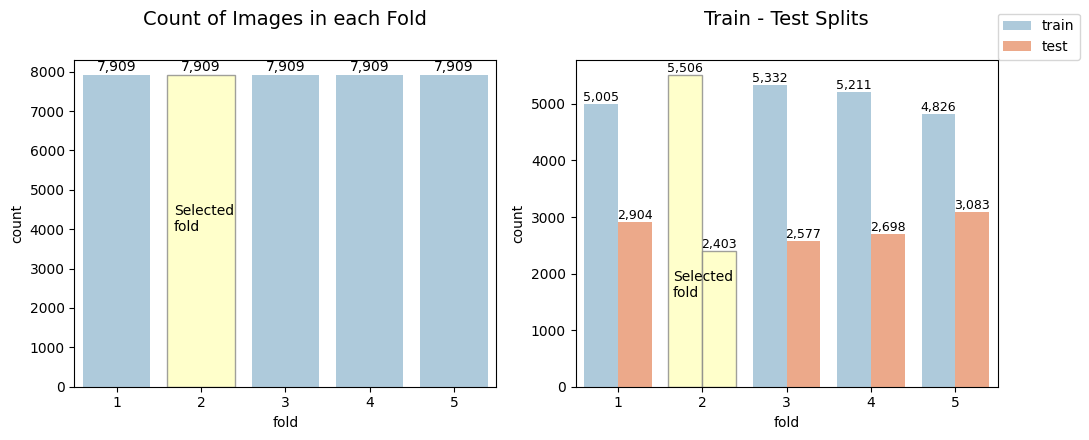

In [24]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy()


selected_fold_data["filename"] = ("/content/drive/MyDrive/"
                                  + selected_fold_data["filename"])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11, 4.5), tight_layout=False)
# Plot image count in each fold
sb.countplot(data=fold_info, x="fold", color="#91bfdb", ax=ax1, alpha=0.8)
bars = ax1.containers[0]
ax1.bar_label(bars, padding=1,
             labels=[f"{x:,.0f}" for x in bars.datavalues])
_selected_bar = bars[selected_fold - 1]
_selected_bar.set_facecolor("#ffffbf")
_selected_bar.set_edgecolor("#888")
ax1.text(_selected_bar.get_x() + 0.08, _selected_bar.get_height() / 2,
         "Selected\nfold")
ax1.set_title("Count of Images in each Fold", size=14, pad=25)
colors=['#91bfdb','#fc8d59']
# Plot train-test split
sb.countplot(data=fold_info, x="fold", hue="grp", palette=colors,
              ax=ax2, alpha=0.8)
for bars in ax2.containers:
    ax2.bar_label(bars, [f"{x:,.0f}" for x in bars.datavalues], size=9)
    bars[selected_fold - 1].set_facecolor("#ffffbf")
    bars[selected_fold - 1].set_edgecolor("#888")
ax2.text(_selected_bar.get_x() + 0.05, _selected_bar.get_height() / 5,
         "Selected\nfold")
ax2.set_title("Train - Test Splits", size=14, pad=25)
ax2.legend(loc=(1, 1));

In [25]:
# Use data in selected fold (2) with magnification factor >= 200X
train = selected_fold_data.query("mag >40 and grp == 'train'")
test = selected_fold_data.query("mag > 40 and grp == 'test'")
train.shape, test.shape


((4143, 5), (1771, 5))

In [ ]:
train

,fold,mag,grp,filename,label
7909,2,100,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,benign
7910,2,100,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,benign
7911,2,100,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,benign
7912,2,100,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,benign
7913,2,100,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,benign
...,...,...,...,...,...
13410,2,400,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,malignant
13411,2,400,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,malignant
13412,2,400,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,malignant
13413,2,400,train,/content/drive/MyDrive/BreaKHis_v1/histology_s...,malignant


Text(0.5, 1.0, 'Class Imbalance in Training Set')

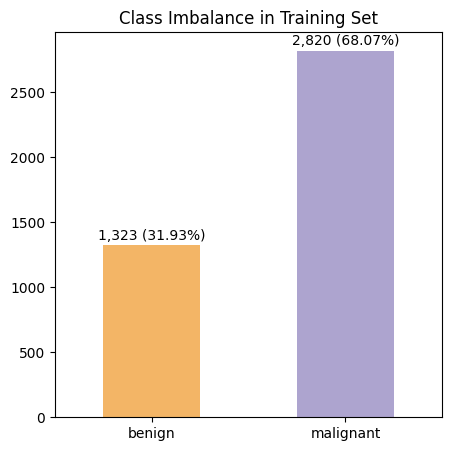

In [29]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["#f1a340", "#998ec3"], alpha=0.8,
                           figsize=(5, 5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);
ax.set_title("Class Imbalance in Training Set")

In [31]:
train_malig=train.loc[train['label'] == 'malignant']
train_benign=train.loc[train['label'] == 'benign']
down_train_malig=df = train_malig.sample(n=433)
down_train=pd.concat([down_train_malig,train_benign])

In [32]:
complete_data=pd.concat([down_train,test])

Text(0.5, 1.0, 'Balanced Training Set')

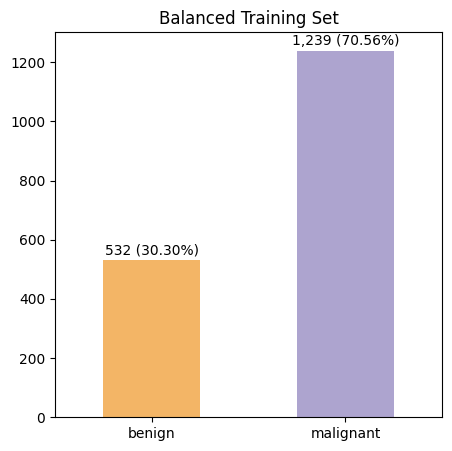

In [33]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = test["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["#f1a340", "#998ec3"], alpha=0.8,
                           figsize=(5, 5))
ax.bar_label(ax.containers[0], padding=2,
             labels=[f"{x:,} ({x/len(down_train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);
ax.set_title("Balanced Training Set")

In [34]:
#IMG_SIZE = (224,224)
BATCH_SIZE = 28

def load_image(filename: str) -> np.ndarray:
    img = Image.open(filename)
    #img = img.resize(IMG_SIZE,resample=Image.LANCZOS)
    img_array = np.array(img)
    return img_array



def extract_features():
    features = []
    labels = []
    count=0
    for index, row in down_train.iterrows():
      print(count)
      count=count+1
      filename=row['filename']
      if filename.endswith(".jpg") or filename.endswith(".png"):
        #plt.figure(figsize=(15, 15))
        #filepath = os.path.join(image_dir, filename)
        img_array = load_image(filename)
        gray_image = rgb2gray(img_array)
        threshold1 = filters.threshold_sauvola(gray_image)
        threshold2 = filters.threshold_niblack(gray_image)
        binarized1 = (gray_image > threshold1)*1
        binarized2 = (gray_image > threshold2)*1
        '''
        plt.subplot(2,2,1)
        plt.imshow(img_array)
        plt.title("Original")
        plt.subplot(2,2,2)
        plt.imshow(gray_image, cmap = "gray")
        plt.title("Grey scale")
        plt.subplot(2,2,3)
        plt.imshow(binarized1, cmap = "gray")
        plt.title("Sauvola Thresholding (Binarized)")
        plt.subplot(2,2,4)
        plt.imshow(binarized2, cmap = "gray")
        plt.title("Niblack Thresholding (Binarized)")
        plt.show()
        '''
        features.append(binarized1)
        labels.append(filename.split("/")[7])  # Assuming filename format is "label_image.png"
        #print(labels)
    return np.array(features), np.array(labels)

def perform_feature_selection(features: np.ndarray, labels: np.ndarray) -> np.ndarray:

    feature_selector = SelectKBest(chi2, k=NUM_FEATURES)
    selected_features = feature_selector.fit_transform(features, labels)
    return selected_features


# Load and extract features from images
features, labels = extract_features()

# Perform feature selection
##selected_features = perform_feature_selection(features, labels)

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(selected_features, labels, test_size=0.2, random_state=random_seed)
'''
X_train, X_valid, y_train, y_valid = train_test_split(
down_train["filename"], down_train["label"].map(classes), random_state=SEED)

train_data = list(zip(X_train, y_train))
validation_data = list(zip(X_valid, y_valid))
test_data = list(zip(test["filename"], test["label"].map(classes)))

def create_dataset(data):
  dataset = []
  for filename, label in data:
    img, lbl = load_image(filename, label)
    dataset.append((img, lbl))
  return dataset


train_ds = create_dataset(train_data)
validation_ds = create_dataset(validation_data)
test_ds = create_dataset(test_data)
'''


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-34-3854d4040ff5>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features), np.array(labels)


'\nX_train, X_valid, y_train, y_valid = train_test_split(\ndown_train["filename"], down_train["label"].map(classes), random_state=SEED)\n\ntrain_data = list(zip(X_train, y_train))\nvalidation_data = list(zip(X_valid, y_valid))\ntest_data = list(zip(test["filename"], test["label"].map(classes)))\n\ndef create_dataset(data):\n  dataset = []\n  for filename, label in data:\n    img, lbl = load_image(filename, label)\n    dataset.append((img, lbl))\n  return dataset\n\n\ntrain_ds = create_dataset(train_data)\nvalidation_ds = create_dataset(validation_data)\ntest_ds = create_dataset(test_data)\n'

In [1]:
labels

NameError: ignored

In [131]:
features.shape

(3512, 224, 224)

In [106]:

for i in range(features.shape[0]):
  array=features[i]
  print(array)
  data = Image.fromarray(array)
  file_name="/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Sauvola/Train/"+str(i)+"/"+str(labels[i])+".png"
  print(file_name)
  data.save('file_name')

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


TypeError: ignored

In [69]:
np.save("/content/drive/MyDrive/BreaKHis_v1/Feature_Sel_Sauvola_40_train_features", features)

In [70]:
np.save("/content/drive/MyDrive/BreaKHis_v1/Feature_Sel_Sauvola_40_train_labels", labels)

In [126]:
check_feature=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Sel_Sauvola_train_labels.npy")

In [128]:
check_feature

array(['malignant', 'malignant', 'malignant', ..., 'benign', 'benign',
       'benign'], dtype='<U9')

In [35]:
feats_x_train=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Sauvola/Training/Feature_Sel_Sauvola_train_features.npy")
feats_x_test=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Sauvola/Testing/Feature_Sel_Sauvola_test_features.npy")

y_train=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Sauvola/Training/Feature_Sel_Sauvola_train_labels.npy")
y_test=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Sauvola/Testing/Feature_Sel_Sauvola_test_labels.npy")

In [19]:
y_train

array(['malignant', 'malignant', 'malignant', ..., 'benign', 'benign',
       'benign'], dtype='<U9')

In [36]:
feats_x_train_re=feats_x_train.reshape(3512,50176)
feats_x_test_re=feats_x_test.reshape(2403,50176)

In [37]:
y_train_re=np.unique(y_train, return_inverse=True)[1].tolist()
y_test_re=np.unique(y_test, return_inverse=True)[1].tolist()


In [38]:
scaler = StandardScaler()
feats_x_train_scaled = scaler.fit_transform(feats_x_train_re)
feats_x_test_scaled = scaler.fit_transform(feats_x_test_re)

# flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

In [39]:
# Train and test a RF classifier (training on slice 60 only)
rf_clf = RandomForestClassifier(n_estimators)
rf_clf.fit(feats_x_train_scaled, y_train_re)

RandomForestClassifier()

In [13]:
label_names=['benign','malignant']

              precision    recall  f1-score   support

      benign       0.28      0.47      0.35       724
   malignant       0.68      0.49      0.57      1679

    accuracy                           0.48      2403
   macro avg       0.48      0.48      0.46      2403
weighted avg       0.56      0.48      0.50      2403



ValueError: ignored

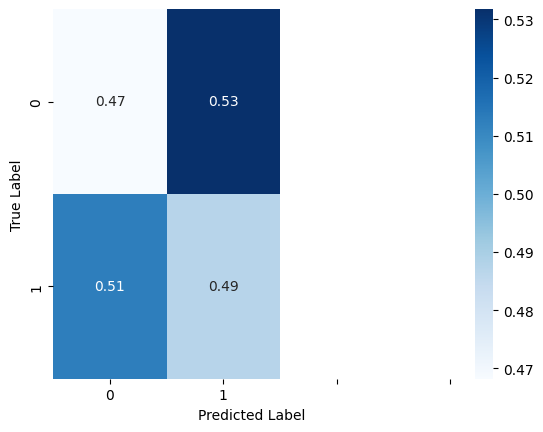

In [41]:
y_predict_test = rf_clf.predict(feats_x_test_scaled)

# Report of results (table)
test_class_report = classification_report(y_test_re, y_predict_test, target_names=label_names)
print(test_class_report)

# Confusion matrix
cm = confusion_matrix(y_test_re, y_predict_test, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5,1.5,2.5,3.5], label_names)
plt.yticks([0.5,1.5,2.5,3.5], label_names)

In [6]:
feats_x_train=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Niblack/Training/Feature_Sel_Niblack_train_features.npy")
feats_x_test=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Niblack/Testing/Feature_Sel_Niblack_test_features.npy")

y_train=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Niblack/Training/Feature_Sel_Niblack_train_labels.npy")
y_test=np.load("/content/drive/MyDrive/BreaKHis_v1/Feature_Selec/Niblack/Testing/Feature_Sel_Niblack_test_labels.npy")

In [7]:
feats_x_train_re=feats_x_train.reshape(3512,50176)
feats_x_test_re=feats_x_test.reshape(2403,50176)

In [8]:
y_train_re=np.unique(y_train, return_inverse=True)[1].tolist()
y_test_re=np.unique(y_test, return_inverse=True)[1].tolist()

In [9]:
scaler = StandardScaler()
feats_x_train_scaled = scaler.fit_transform(feats_x_train_re)
feats_x_test_scaled = scaler.fit_transform(feats_x_test_re)

# flatten labels
y_train = y_train.ravel()
y_test = y_test.ravel()

In [11]:
# Train and test a RF classifier (training on slice 60 only)
rf_clf = RandomForestClassifier(n_estimators=500)
rf_clf.fit(feats_x_train_scaled, y_train_re)

RandomForestClassifier(n_estimators=500)

              precision    recall  f1-score   support

      benign       0.40      0.65      0.49       724
   malignant       0.79      0.59      0.67      1679

    accuracy                           0.60      2403
   macro avg       0.60      0.62      0.58      2403
weighted avg       0.67      0.60      0.62      2403



ValueError: ignored

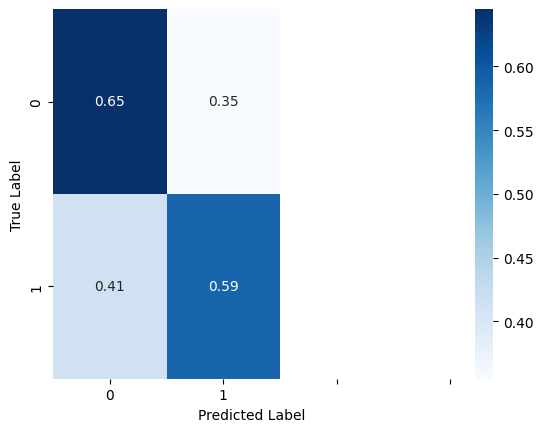

In [16]:
y_predict_test = rf_clf.predict(feats_x_test_scaled)

# Report of results (table)
test_class_report = classification_report(y_test_re, y_predict_test, target_names=label_names)
print(test_class_report)

# Confusion matrix
cm = confusion_matrix(y_test_re, y_predict_test, normalize='true')
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5,1.5,2.5,3.5], label_names)
plt.yticks([0.5,1.5,2.5,3.5], label_names)